In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from scipy.stats import norm, gmean, cauchy, multivariate_normal
import seaborn as sns
# import plotly as py
# import plotly.graph_objs as go
# import cufflinks
# cufflinks.go_offline(connected=True)
#init_notebook_mode(connected=True)
import yfinance as yfin

yfin.pdr_override()
%matplotlib inline

In [2]:
def import_stock_data(tickers, start = '2010-1-1'):
    data = pd.DataFrame()
    if len(tickers) == 1:
        data[tickers[0]] = pdr.get_data_yahoo(tickers[0], start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = pdr.get_data_yahoo(t, start = start)['Adj Close']
    return(data)

In [3]:
data = import_stock_data(["MSFT","BAM"])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
data.tail()

,MSFT,BAM
Date,,
2023-05-26,332.890015,30.750000
2023-05-30,331.209991,30.809999
2023-05-31,328.390015,30.520000
2023-06-01,332.579987,30.799999
2023-06-02,334.749908,31.459999


In [5]:
def log_returns(data):
    return (np.log(1+data.pct_change()))

In [6]:
log_return = log_returns(data)

In [7]:
def drift_calc(data, return_type='log'):
    if return_type=='log':
        lr = log_returns(data)
    elif return_type=='simple':
        lr = simple_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(0.5*var)
    try:
        return drift.values
    except:
        return drift

In [8]:
drif = drift_calc(data)
drif

array([ 0.00065081, -0.00018184])

In [9]:
covi = log_return.cov()
covi

,MSFT,BAM
MSFT,0.000270,0.000083
BAM,0.000083,0.000409


In [10]:
L = np.linalg.cholesky(covi)
L

array([[0.01643896, 0.        ],
       [0.00505631, 0.01956961]])

In [11]:
randi =norm.ppf(np.random.rand(2,2))
randi

array([[ 1.55707112, -0.14980985],
       [ 0.65538931,  0.7351811 ]])

In [12]:
V = L.dot(randi)

In [13]:
V[0]+drif[0]
V[1]+drif[1]

array([0.02051691, 0.01344789])

In [14]:
def daily_returns(data, days, iterations, return_type='log'):
    ft = drift_calc(data, return_type)
    if return_type == 'log':
        try:
            stv = log_returns(data).std().values
        except:
            stv = log_returns(data).std()
    elif return_type=='simple':
        try:
            stv = simple_returns(data).std().values
        except:
            stv = simple_returns(data).std()    
    covall = log_return.cov()
    chol = np.linalg.cholesky(covall)
    numstocks = len(data.columns)
    
    randim = norm.ppf(np.random.rand(days,numstocks,iterations))
    V = chol.dot(randim)
    
    stocks = []
    for s in range(numstocks):
        dr = np.exp(ft[s] + stv[s] * V[s])
        stocks.append(dr)
    return stocks

In [15]:
xxx = daily_returns(data, days = 250, iterations = 10)
xxx

[array([[1.00046001, 1.00098683, 1.00083976, ..., 1.00045635, 1.00093787,
         1.00042923],
        [1.00068454, 1.0007221 , 1.00038582, ..., 1.00089953, 1.00007322,
         1.00072407],
        [1.00083475, 1.00077407, 1.00038329, ..., 1.00068408, 1.00062902,
         1.00075765],
        ...,
        [1.00079632, 1.00056087, 1.00058322, ..., 1.00044499, 1.00047406,
         1.00067253],
        [1.00078518, 1.00070771, 1.00079226, ..., 1.00056336, 1.00041582,
         1.00037438],
        [1.00093146, 1.00050906, 1.0007427 , ..., 1.00099091, 1.0010703 ,
         1.00040081]]),
 array([[0.99989397, 0.99995006, 0.99934749, ..., 0.99963725, 0.9994261 ,
         0.99990124],
        [0.99983706, 1.00069189, 0.99929193, ..., 0.99892772, 0.99952926,
         0.9987723 ],
        [1.0001405 , 0.99961661, 0.99954676, ..., 0.99956009, 0.99893021,
         0.99996424],
        ...,
        [0.99977626, 0.99940174, 0.99886443, ..., 0.99944258, 0.99920661,
         1.00007651],
        [1.0

In [16]:
def daily_returns(data, days, iterations, return_type='log'):
    ft = drift_calc(data, return_type)
    if return_type == 'log':
        try:
            stv = log_returns(data).std().values
        except:
            stv = log_returns(data).std()
    elif return_type=='simple':
        try:
            stv = simple_returns(data).std().values
        except:
            stv = simple_returns(data).std()   
    
    numstocks = len(data.columns)
    
    covall = log_return.cov()
    chol = np.linalg.cholesky(covall)
    
    # totals = []
    # for d in range(days):
    #     uncorr_x = np.random.normal(0,1,(numstocks,iterations))
    #     corr_x = np.dot(chol,uncorr_x)
    #     df = pd.DataFrame(corr_x[0]).T
    #     totals.append(df)
            #print(corr_x[0])
    simstock = np.zeros_like(5)
    for d in range(days):
        uncorr_x = np.random.normal(0,1,(2,5))
        corr_x = np.dot(chol,uncorr_x)
        row = (corr_x[0]).transpose()
        simstock = simstock+row
        # print(row)
    # return simstock
    randim = norm.ppf(np.random.rand(days,numstocks,iterations))
    V = chol.dot(randim)
    
    stocks = []
    for s in range(numstocks):
        dr = np.exp(ft[s] + stv[s] * V[s])
        stocks.append(dr)
    return  stocks
#     randim = norm.ppf(np.random.rand(days,numstocks,iterations))
#     V = chol.dot(randim)
    
#     stocks = []
#     for s in range(numstocks):
#         dr = np.exp(ft[s] + stv[s] * V[s])
#         stocks.append(dr)
    # return pd.DataFrame(totals)

In [17]:
xxx = daily_returns(data, days = 250, iterations = 10)
# pd.DataFrame(xxx)

In [18]:
stock1 = xxx[0]
stock2 = xxx[1]

In [19]:
stock1

array([[1.00082317, 1.00111623, 1.00073746, ..., 1.00107113, 1.00071594,
        1.000114  ],
       [1.00069514, 1.00026837, 1.00076103, ..., 1.00020408, 1.00066799,
        1.00090647],
       [1.0005982 , 1.00080595, 1.00065423, ..., 1.00108901, 1.00110698,
        1.0004095 ],
       ...,
       [1.00087048, 1.00113014, 1.00067517, ..., 1.0007497 , 1.00080756,
        1.00102884],
       [1.00052665, 1.00042285, 1.00037913, ..., 1.00071785, 1.00062018,
        1.00130873],
       [1.00081025, 1.00046123, 1.00041245, ..., 1.00085816, 1.00031258,
        1.0001162 ]])

In [20]:
price_list1 = np.zeros_like(stock1)
price_list2 = np.zeros_like(stock2)

In [21]:
price_list1[0] = data.iloc[-1,0]
price_list2[0] = data.iloc[-1,1]

In [22]:
for t in range(1,250):
    price_list1[t] = price_list1[t-1]*stock1[t]
    price_list2[t] = price_list2[t-1]*stock2[t]

<AxesSubplot:>

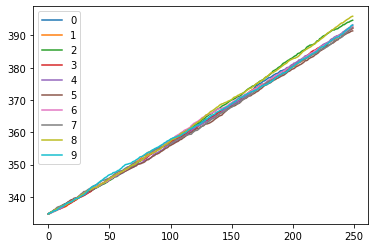

In [23]:
pd.DataFrame(price_list1).plot()

In [24]:
stv = log_returns(data).std()
stv.values

array([0.01643896, 0.02021227])

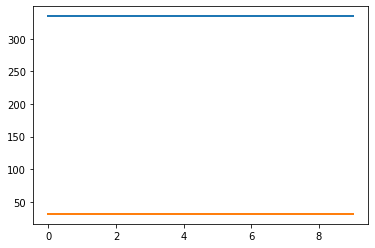

In [25]:
plt.plot(price_list1[0], label = 'stock A', linewidth = 2)
plt.plot(price_list2[0], label = 'stock B', linewidth = 2)

In [26]:
np.random.multivariate_normal((log_return.mean()),covi,20)

array([[ 0.00768612,  0.02703674],
       [ 0.00329802, -0.00967265],
       [-0.02255388, -0.02298531],
       [ 0.00886242, -0.04029271],
       [ 0.01943872,  0.0190393 ],
       [ 0.01221647, -0.01120713],
       [ 0.01478134, -0.01701865],
       [-0.0217101 , -0.02131688],
       [-0.01016738, -0.00988724],
       [-0.0204849 , -0.00828122],
       [ 0.01768906,  0.0189116 ],
       [ 0.01129909,  0.02132089],
       [-0.01961936,  0.02109863],
       [-0.02677214, -0.00676592],
       [ 0.02081115, -0.01596941],
       [-0.02620391, -0.00990758],
       [ 0.01594588, -0.01704012],
       [ 0.03508048,  0.0031943 ],
       [ 0.01464812,  0.01087545],
       [-0.02266855, -0.01066961]])